Точное значение интеграла (scipy): 0.460043630500

N        | Simpson Integral   | Simpson Err   | p_value    | Aitken Err   
---------------------------------------------------------------------------
2        | 0.700989211        | 2.41e-01      | -          | -            
4        | 0.262153384        | 1.98e-01      | 0.28       | -            
8        | 0.465985770        | 5.94e-03      | 5.06       | 5.87e-02     
16       | 0.462329552        | 2.29e-03      | 1.38       | 2.35e-03     
32       | 0.460930830        | 8.87e-04      | 1.37       | 2.06e-05     
64       | 0.460256766        | 2.13e-04      | 2.06       | 4.14e-04     
128      | 0.459921291        | 1.22e-04      | 0.80       | 4.55e-04     
256      | 0.460055629        | 1.20e-05      | 3.35       | 2.64e-05     
512      | 0.460047434        | 3.80e-06      | 1.66       | 4.28e-06     
1024     | 0.460043338        | 2.93e-07      | 3.70       | 4.39e-06     
2048     | 0.460043748        | 1.17e-07      | 

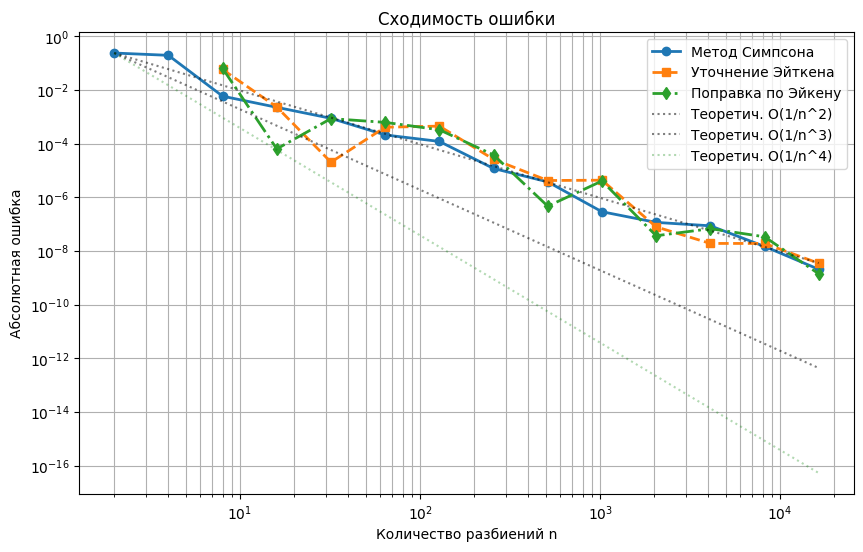

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Функция
func = lambda x: np.abs(np.cos(np.sin(x)) - 3/4)

# Составной метод Симпсона
def simpson_method(f, a, b, n):
    h = (b - a) / n
    
    integral = f(a) + f(b)
    
    sum_odd = 0
    for i in range(1, n, 2):
        sum_odd += f(a + i * h)
        
    sum_even = 0
    for i in range(2, n, 2):
        sum_even += f(a + i * h)
        
    integral = (h / 3) * (integral + 4 * sum_odd + 2 * sum_even)
    return integral

# Процесс Эйткена
def aitken_process(I_h, I_2h, I_4h):
    numerator = (I_h - I_2h) ** 2
    denominator = (I_h - 2 * I_2h + I_4h)

    return I_h - (numerator / denominator)

def main():
    a, b = 0.0, np.pi
    epsilon = 1e-4
    
    # Точное значение через SciPy
    exact_integral, _ = quad(func, a, b, limit=100)
    print(f"Точное значение интеграла (scipy): {exact_integral:.12f}\n")

    # Списки значений
    n_values = []
    errors_simpson = []
    errors_aitken = []
    # НОВОЕ: оценка поправки Эйткена (модуль поправки, которую вычитают из I_h)
    errors_aitken_correction = []

    # История вычислений
    history = [] 
    
    print(f"{'N':<8} | {'Simpson Integral':<18} | {'Simpson Err':<13} | {'p_value':<10} | {'Aitken Err':<13}")
    print("-" * 75)

    # Цикл по степеням двойки
    for k in range(1, 15): 
        n = 2**k
        
        # Симпсон и ошибка
        val_simp = simpson_method(func, a, b, n)
        err_simp = abs(val_simp - exact_integral)
        
        history.append(val_simp)
        n_values.append(n)
        errors_simpson.append(err_simp)
        
        # Расчет порядка сходимости (p_eff)
        p_value = "-"
        if len(errors_simpson) >= 2:
            if errors_simpson[-1] > 0:
                p = np.log2(errors_simpson[-2] / errors_simpson[-1])
                p_value = f"{p:.2f}"
        
        # Процесс Эйткена
        err_aitken_str = "-"
        # НОВОЕ: строка для вывода поправки (не обязательна, оставляем для консистенции)
        if len(history) >= 3:
            I_h = history[-1]
            I_2h = history[-2]
            I_4h = history[-3]
            
            # Вычисляем поправку (Delta) и само уточнение
            numerator = (I_h - I_2h) ** 2
            denominator = (I_h - 2 * I_2h + I_4h)
            if denominator != 0:
                correction = numerator / denominator   # это та самая поправка, которую вы вычитаете из I_h
                val_aitken = I_h - correction
                err_aitken = abs(val_aitken - exact_integral)
                errors_aitken.append(err_aitken)
                errors_aitken_correction.append(abs(correction))  # модуль поправки — оценка ошибки Симпсона
                err_aitken_str = f"{err_aitken:.2e}"
            else:
                # вырожденный случай, пропускаем оценку
                errors_aitken.append(None)
                errors_aitken_correction.append(None)
        else:
            errors_aitken.append(None)
            errors_aitken_correction.append(None)

        print(f"{n:<8} | {val_simp:<18.9f} | {err_simp:<13.2e} | {p_value:<10} | {err_aitken_str:<13}")

    # Построение графика
    plt.figure(figsize=(10, 6))
    
    ref_x = np.array(n_values, dtype=float) 
    
    # График метода Симпсона
    plt.loglog(ref_x, errors_simpson, 'o-', label='Метод Симпсона', linewidth=2)
    
    valid_n_aitken = [n_values[i] for i in range(len(errors_aitken)) if errors_aitken[i] is not None]
    valid_err_aitken = [errors_aitken[i] for i in range(len(errors_aitken)) if errors_aitken[i] is not None]
    
    # График процесса Эйткена (фактическая ошибка после применения Эйткена)
    plt.loglog(valid_n_aitken, valid_err_aitken, 's--', label='Уточнение Эйткена', linewidth=2)
    
    # НОВОЕ: график оценки ошибки по Эйкену — модуль поправки (то, что вы вычитаете из I_h)
    valid_n_corr = [n_values[i] for i in range(len(errors_aitken_correction)) if errors_aitken_correction[i] is not None]
    valid_err_corr = [errors_aitken_correction[i] for i in range(len(errors_aitken_correction)) if errors_aitken_correction[i] is not None]
    if len(valid_n_corr) > 0:
        plt.loglog(valid_n_corr, valid_err_corr, 'd-.', label='Поправка по Эйкену', linewidth=2)

    # Асимптотики разных порядков
    if len(errors_simpson) > 0:
        # Линия 2-го порядка
        ref_y2 = ref_x**(-2) * errors_simpson[0] * (ref_x[0]**2)
        plt.loglog(ref_x, ref_y2, 'k:', alpha=0.5, label='Теоретич. O(1/n^2)')
        
        # Линия 3-го порядка
        ref_y3 = ref_x**(-3) * errors_simpson[0] * (ref_x[0]**3)
        plt.loglog(ref_x, ref_y3, 'k:', alpha=0.5, label='Теоретич. O(1/n^3)')
        
        # Линия 4-го порядка
        ref_y4 = ref_x**(-4) * errors_simpson[0] * (ref_x[0]**4)
        plt.loglog(ref_x, ref_y4, 'g:', alpha=0.3, label='Теоретич. O(1/n^4)')

    plt.grid(True, which="both", ls="-")
    plt.xlabel('Количество разбиений n')
    plt.ylabel('Абсолютная ошибка')
    plt.title('Сходимость ошибки')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()